In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import time
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, OrdinalEncoder, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

---
## Variable Target

Para abordar el problema como una tarea de clasificación, consideraremos la temperatura media anual de cada estación, representada por la variable 'Temperatura'. A partir de su valor crearemos una variable categórica que represente el clima de cada estación y que será la variable target:

Frías: promedio menor a 10 °C

Templadas frescas: entre 10 °C y 15 °C

Templadas cálidas: entre 15 °C y 20 °C

Cálidas: promedio mayor a 20 °C

Esta clasificación busca representar de manera más precisa la variabilidad climática del país. A continuación, se agruparon las observaciones por estación y se asignó una etiqueta a cada una según el promedio de temperatura.

In [80]:
# Agrupamos por estación y calculamos el promedio de temperatura de cada una considerando todos los meses y años
df_temperatura_estacion = df_91_20.groupby("Estación")["Temperatura"].mean().reset_index()

# Creamos la variable target

def clasificar_temp(temperatura):
    if temperatura < 10:
        return "fría"
    elif temperatura < 15:
        return "templada fresca"
    elif temperatura < 20:
        return "templada cálida"
    else:
        return "cálida"

df_temperatura_estacion["CLASE"] = df_temperatura_estacion["Temperatura"].apply(clasificar_temp)

# Agregamos por estación todas las variables numéricas
df_agregado = df_91_20.groupby("Estación").mean(numeric_only=True).reset_index()

# Mergeamos con las clases y eliminamos columnas de temperatura y el booleano de "viento_medido". 
# También eliminamos la columna "Estación" porque los nombres de las estaciones no son relevantes para el modelo.
df_final = pd.merge(df_agregado, df_temperatura_estacion[["Estación", "CLASE"]], on="Estación")
df_final = df_final.drop(columns=["Temperatura", "Temperatura Máx.", "Temperatura Mín.", "Viento_medido", "Estación"])

In [66]:
print(df_final["CLASE"].value_counts())
df_final.head(5)

CLASE
templada cálida    50
templada fresca    19
fría               15
cálida             14
Name: count, dtype: int64


,Precipitación,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Viento,CLASE
0,92.241667,5.925000,71.441667,3.625000,15.041667,templada cálida
1,77.958333,5.558333,74.100000,3.733333,NaN,templada fresca
2,53.258333,4.975000,64.641667,3.575000,18.225000,templada cálida
3,67.708333,6.816667,65.016667,4.008333,19.550000,fría
4,68.277707,5.099357,68.061130,4.608333,NaN,fría


Ahora tenemos el df_final con todos los parámetros que pueden ser relevantes para la predicción y las etiquetas generadas al crear la variable target. Todas las variables resultan ser de tipo numéricas.

---
## Desbalance de clases

Se nota un fuerte desbalance de clases siendo la clase "templada cálida" fuertemente predominante. Este desbalance puede afectar negativamente la capacidad del modelo para aprender patrones representativos de las clases minoritarias y esto puede llevar a modelos sesgados o con bajo poder predictivo. Graficamos para mayor claridad: 

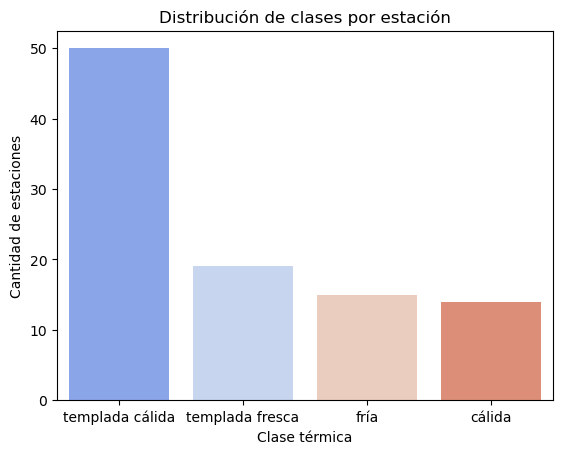

In [67]:
sns.countplot(data=df_temperatura_estacion, x="CLASE", hue="CLASE", palette="coolwarm", legend=False)
plt.title("Distribución de clases por estación")
plt.xlabel("Clase térmica")
plt.ylabel("Cantidad de estaciones")
plt.show()

Para corregir este sobremuestreo elegimos aplicar sobremuestreo con SMOTE a las clases minoritarias en lugar de un submuestreo de la clase mayoritaria ya que nos permite conservar mayor cantidad de datos y ayuda a evitar el overfitting. 

Primero imputamos los valores faltantes y transformamos las variables categóricas en los pipelines.

In [68]:
# Definimos variables numéricas excluyendo las variables de temperatura (target implícito)
numericas = df_final.select_dtypes(include='number').columns.tolist()

# Pipelines para imputación y encoding
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

#categorical_pipeline = Pipeline([
   # ("imputer", SimpleImputer(strategy="most_frequent")),
   # ("encoder", OneHotEncoder(handle_unknown='ignore'))
#])

# ColumnTransformer para las variables
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numericas)
])

# Dividimos el dataset antes del preprocesamiento para evitar el data leakage
X = df_final.drop(columns=["CLASE"])
y = df_final["CLASE"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ajustamos sólo con el set de entrenamiento
preprocessor.fit(X_train)

# Obtenemos los nombres de los features 
feature_names = preprocessor.get_feature_names_out()

#Transformamos
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# SMOTE sobre el set de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_prep, y_train)

print(y_train_res.value_counts())

CLASE
templada cálida    40
fría               40
cálida             40
templada fresca    40
Name: count, dtype: int64


Luego de aplicar SMOTE sobre el set de entrenamiento vemos que ahora se logró una distribución balanceada de clases (40 estaciones cada una), esto proporciona una buena base para el posterior entrenamiento del modelo. Nótese que en lugar de obtener 50 estaciones por clase, al haber hecho la división de 80/20 antes de SMOTE la clase mayoritaria pasó a tener 40 ítems, eso explica este número para las demás clases.

--- 
## Análisis y selección de features

Ahora vamos a identificar qué variables son más relevantes para predecir la variable target dado que ya tenemos el set X_train_res (balanceado y preprocesado) y y_train_res.

Para evaluar la relevancia de los atributos predictivos respecto a la variable objetivo CLASE, vamos a aplicar ANOVA y Información Mutua. 

**ANOVA**

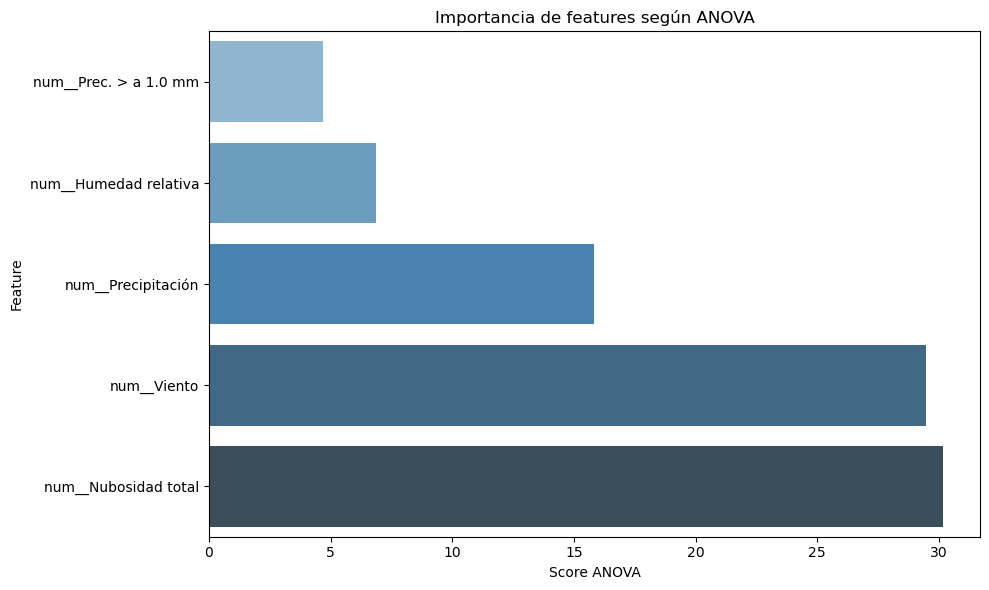

In [69]:
# ANOVA
anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X_train_res, y_train_res)
anova_scores = anova_selector.scores_

# Gráfico ANOVA
df_anova = pd.DataFrame({
    "Feature": feature_names,
    "ANOVA": anova_scores
}).sort_values(by="ANOVA", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_anova, x="ANOVA", y="Feature", palette="Blues_d", hue="Feature", legend=False)
plt.title("Importancia de features según ANOVA")
plt.xlabel("Score ANOVA")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Puede verse en base al análisis de ANOVA que las variables que mejor pueden ayudar en la predicción de nuestro modelo son Nubosidad Total y Viento. Esto puede deberse a que las zonas frías suelen tener mayor nubosidad, mientras que las zonas cálidas suelen tener cielos más despejados. El viento también está relacionado con la temperatura: en zonas frías, los vientos son generalmente más intensos y persistentes.

Las precipitaciones tienen menos incidencia en la predicción (cerca de 15 en este Test) pero como vimos en la primera parte de este Trabajo Práctico suele haber una correlación entre las mismas y las temperaturas (a mayores temperaturas, mayores lluvias).

**Información Mutua**

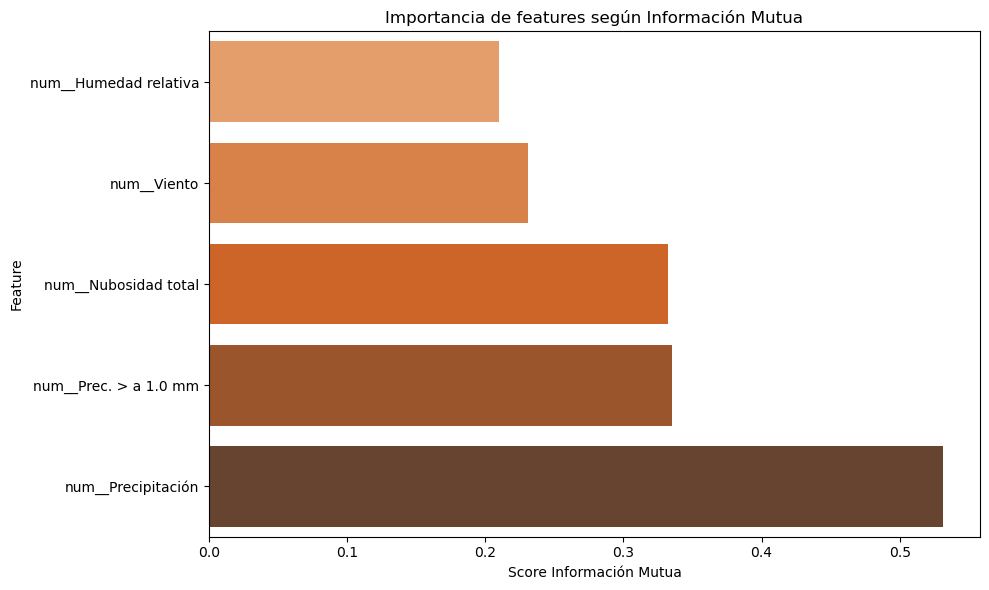

In [70]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Información Mutua
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X_train_res, y_train_res)
mi_scores = mi_selector.scores_

# Gráfico Información Mutua
df_mi = pd.DataFrame({
    "Feature": feature_names,
    "InfoMutua": mi_scores
}).sort_values(by="InfoMutua", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_mi, x="InfoMutua", y="Feature", palette="Oranges_d", hue="Feature", legend=False)
plt.title("Importancia de features según Información Mutua")
plt.xlabel("Score Información Mutua")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

A diferencia de con ANOVA, donde Nubosidad y Viento fueron los más relevantes, en Información Mutua la variable más informativa fue Precipitación, seguida por Nubosidad y Prec. > a 1 mm. Esto sugiere que, aunque no hay grandes diferencias de medias entre clases, sí hay una dependencia estadística entre la cantidad de precipitación y el tipo de clima, posiblemente en patrones más complejos o no lineales. Como ya marcamos que vimmos en el tarbajo anterior.

--- 
## Selección de features

Para seleccionar los features nos guiamos en los resultados de los tests que acabamos de realizar.

Estas serán las siguientes variables:

Nubosidad total → alta relevancia tanto en ANOVA como en Información Mutua.

Precipitación → destaca principalmente en Información Mutua.

Viento → muy relevante en ANOVA, y aceptable en Información Mutua.


In [71]:
# Lista de features seleccionadas
features_seleccionadas = [
    'Nubosidad total',
    'Precipitación',
    'Viento'
]

Esta reducción de dimensionalidad mantendrá la capacidad predictiva del modelo y mejorará su interpretabilidad. 

No consideramos necesario crear nuevos features.

--- 
## Transformación de variables


NOTA: *el siguiente código trabaja también con las variables categóricas "Estación" y "Mes" pese a que en realidad no las seleccionamos como features.*


=== ANÁLISIS DE FEATURES SELECCIONADAS ===
Features numéricas: ['Nubosidad total', 'Precipitación', 'Viento']
Features categóricas: ['Estación', 'Mes']

Estadísticas descriptivas de features numéricas:
       Nubosidad total  Precipitación      Viento
count      1166.000000    1171.000000  708.000000
mean          3.840137      68.267633   13.011582
std           0.888284      49.832699    5.554040
min           1.300000       0.000000    3.900000
25%           3.300000      24.750000    9.200000
50%           3.700000      60.300000   11.800000
75%           4.200000     103.300000   15.900000
max           7.500000     277.900000   36.500000


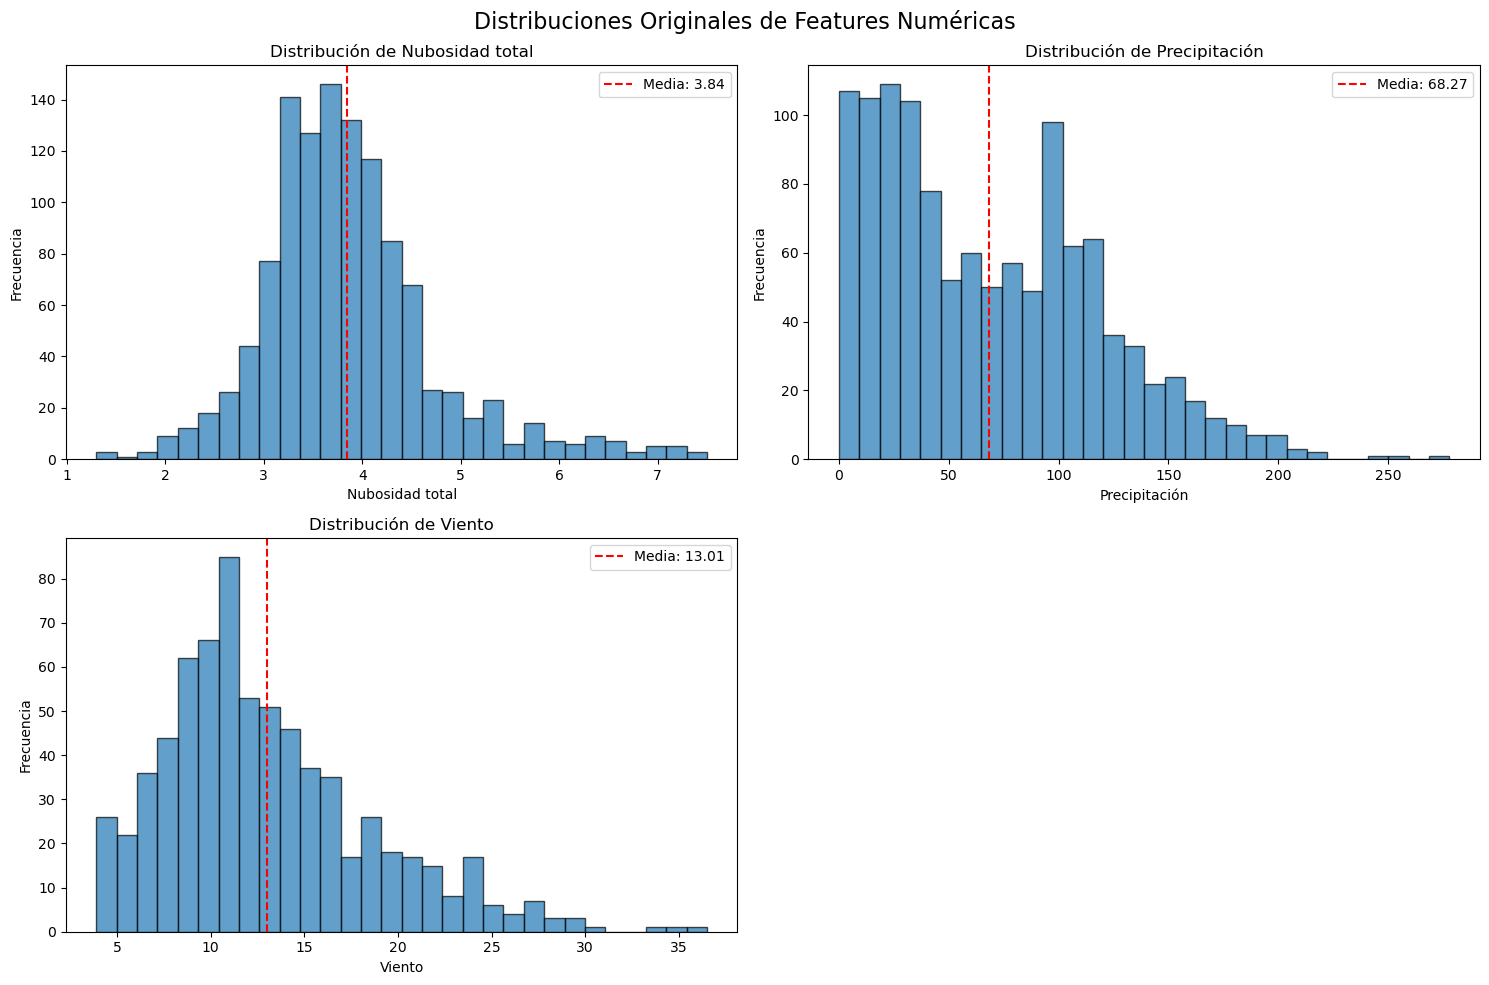

In [72]:
# Features seleccionadas
features_numericas = ['Nubosidad total', 'Precipitación', 'Viento']
features_categoricas = ['Estación', 'Mes']

# Crear DataFrame con features
X = df_91_20[features_numericas+features_categoricas].copy()

print(f"\n=== ANÁLISIS DE FEATURES SELECCIONADAS ===")
print(f"Features numéricas: {features_numericas}")
print(f"Features categóricas: {features_categoricas}")
print(f"\nEstadísticas descriptivas de features numéricas:")
print(X[features_numericas].describe())

# Análisis de distribuciones antes de la transformación
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribuciones Originales de Features Numéricas', fontsize=16)

for i, feature in enumerate(features_numericas):
    row = i // 2
    col = i % 2
    
    # Histograma
    axes[row, col].hist(X[feature], bins=30, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'Distribución de {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frecuencia')
    
    # Estadísticas
    mean_val = X[feature].mean()
    std_val = X[feature].std()
    axes[row, col].axvline(mean_val, color='red', linestyle='--', 
                          label=f'Media: {mean_val:.2f}')
    axes[row, col].legend()

# Para eliminar el subplot vacío 
if len(features_numericas) % 2 != 0:
    fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

## Codificacion de variables categoricas

In [73]:
print(f"\n=== ANÁLISIS DE FEATURES CATEGÓRICAS ===")
for feature in features_categoricas:
    print(f"\n{feature}:")
    print(f"Valores únicos: {X[feature].nunique()}")
    print(f"Valores: {X[feature].unique()}")
    print(f"Distribución:")
    print(X[feature].value_counts())

print(f"\n=== CODIFICACIÓN DE VARIABLES CATEGÓRICAS ===")

# Para 'Mes' usaremos codificación ordinal (orden estacional)
meses_orden = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

# Para 'Estación' usaremos One-Hot Encoding (no hay orden natural)
print("Aplicando codificación ordinal para 'Mes' (orden estacional)")
print("Aplicando One-Hot Encoding para 'Estación' (variables nominales)")

print(f"\n=== DISCRETIZACIÓN DE VARIABLES CONTINUAS ===")

# Discretizar precipitación en categorías (Baja, Media, Alta)
precipitation_bins = [0, 50, 100, float('inf')]
precipitation_labels = ['Baja', 'Media', 'Alta']

X_discretized = X.copy()
X_discretized['Precipitación_cat'] = pd.cut(X['Precipitación'], 
                                           bins=precipitation_bins, 
                                           labels=precipitation_labels, 
                                           include_lowest=True)

print("Discretización de Precipitación:")
print(X_discretized['Precipitación_cat'].value_counts())



=== ANÁLISIS DE FEATURES CATEGÓRICAS ===

Estación:
Valores únicos: 98
Valores: ['AEROPARQUE AERO' 'AZUL AERO*' 'BAHÍA BLANCA AERO' 'BARILOCHE AERO'
 'BASE BELGRANO II' 'BASE CARLINI (EX JÚBANY)' 'BASE ESPERANZA'
 'BASE MARAMBIO' 'BASE ORCADAS' 'BASE SAN MARTÍN'
 'BERNARDO DE IRIGOYEN AERO' 'BOLÍVAR AERO' 'BUENOS AIRES OBSERVATORIO'
 'CATAMARCA AERO' 'CERES AERO' 'CHAMICAL AERO' 'CHILECITO AERO'
 'COMODORO RIVADAVIA AERO' 'CONCORDIA AERO' 'CORONEL PRINGLES AERO*'
 'CORONEL SUÁREZ AERO' 'CORRIENTES AERO' 'CÓRDOBA AERO'
 'CÓRDOBA OBSERVATORIO' 'DOLORES AERO' 'EL BOLSÓN AERO*'
 'EL CALAFATE AERO*' 'EL PALOMAR AERO' 'EL TRÉBOL' 'ESQUEL AERO'
 'EZEIZA AERO' 'FORMOSA AERO' 'GENERAL PICO AERO'
 'GOBERNADOR GREGORES AERO*' 'GUALEGUAYCHÚ AERO' 'IGUAZÚ AERO' 'JACHAL'
 'JUJUY AERO' 'JUJUY U N' 'JUNÍN AERO' 'LA PLATA AERO'
 'LA QUIACA OBSERVATORIO' 'LA RIOJA AERO' 'LABOULAYE AERO' 'LAS FLORES'
 'LAS LOMITAS' 'MALARGÜE AERO' 'MAQUINCHAO' 'MAR DEL PLATA AERO'
 'MARCOS JUÁREZ AERO' 'MENDOZA AERO' 'M

## Escalado y normalizacion


=== ESCALADO Y NORMALIZACIÓN ===
Comparando diferentes métodos de escalado:

--- StandardScaler ---
Estadísticas después de StandardScaler:
      num__Nubosidad total  num__Precipitación  num__Viento
mean                -0.000               0.000       -0.000
std                  1.000               1.000        1.000
min                 -2.866              -1.371       -1.982
max                  4.131               4.209        5.502

--- MinMaxScaler ---
Estadísticas después de MinMaxScaler:
      num__Nubosidad total  num__Precipitación  num__Viento
mean                 0.410               0.246        0.265
std                  0.143               0.179        0.134
min                  0.000               0.000        0.000
max                  1.000               1.000        1.000

--- RobustScaler ---
Estadísticas después de RobustScaler:
      num__Nubosidad total  num__Precipitación  num__Viento
mean                 0.155               0.101        0.366
std                

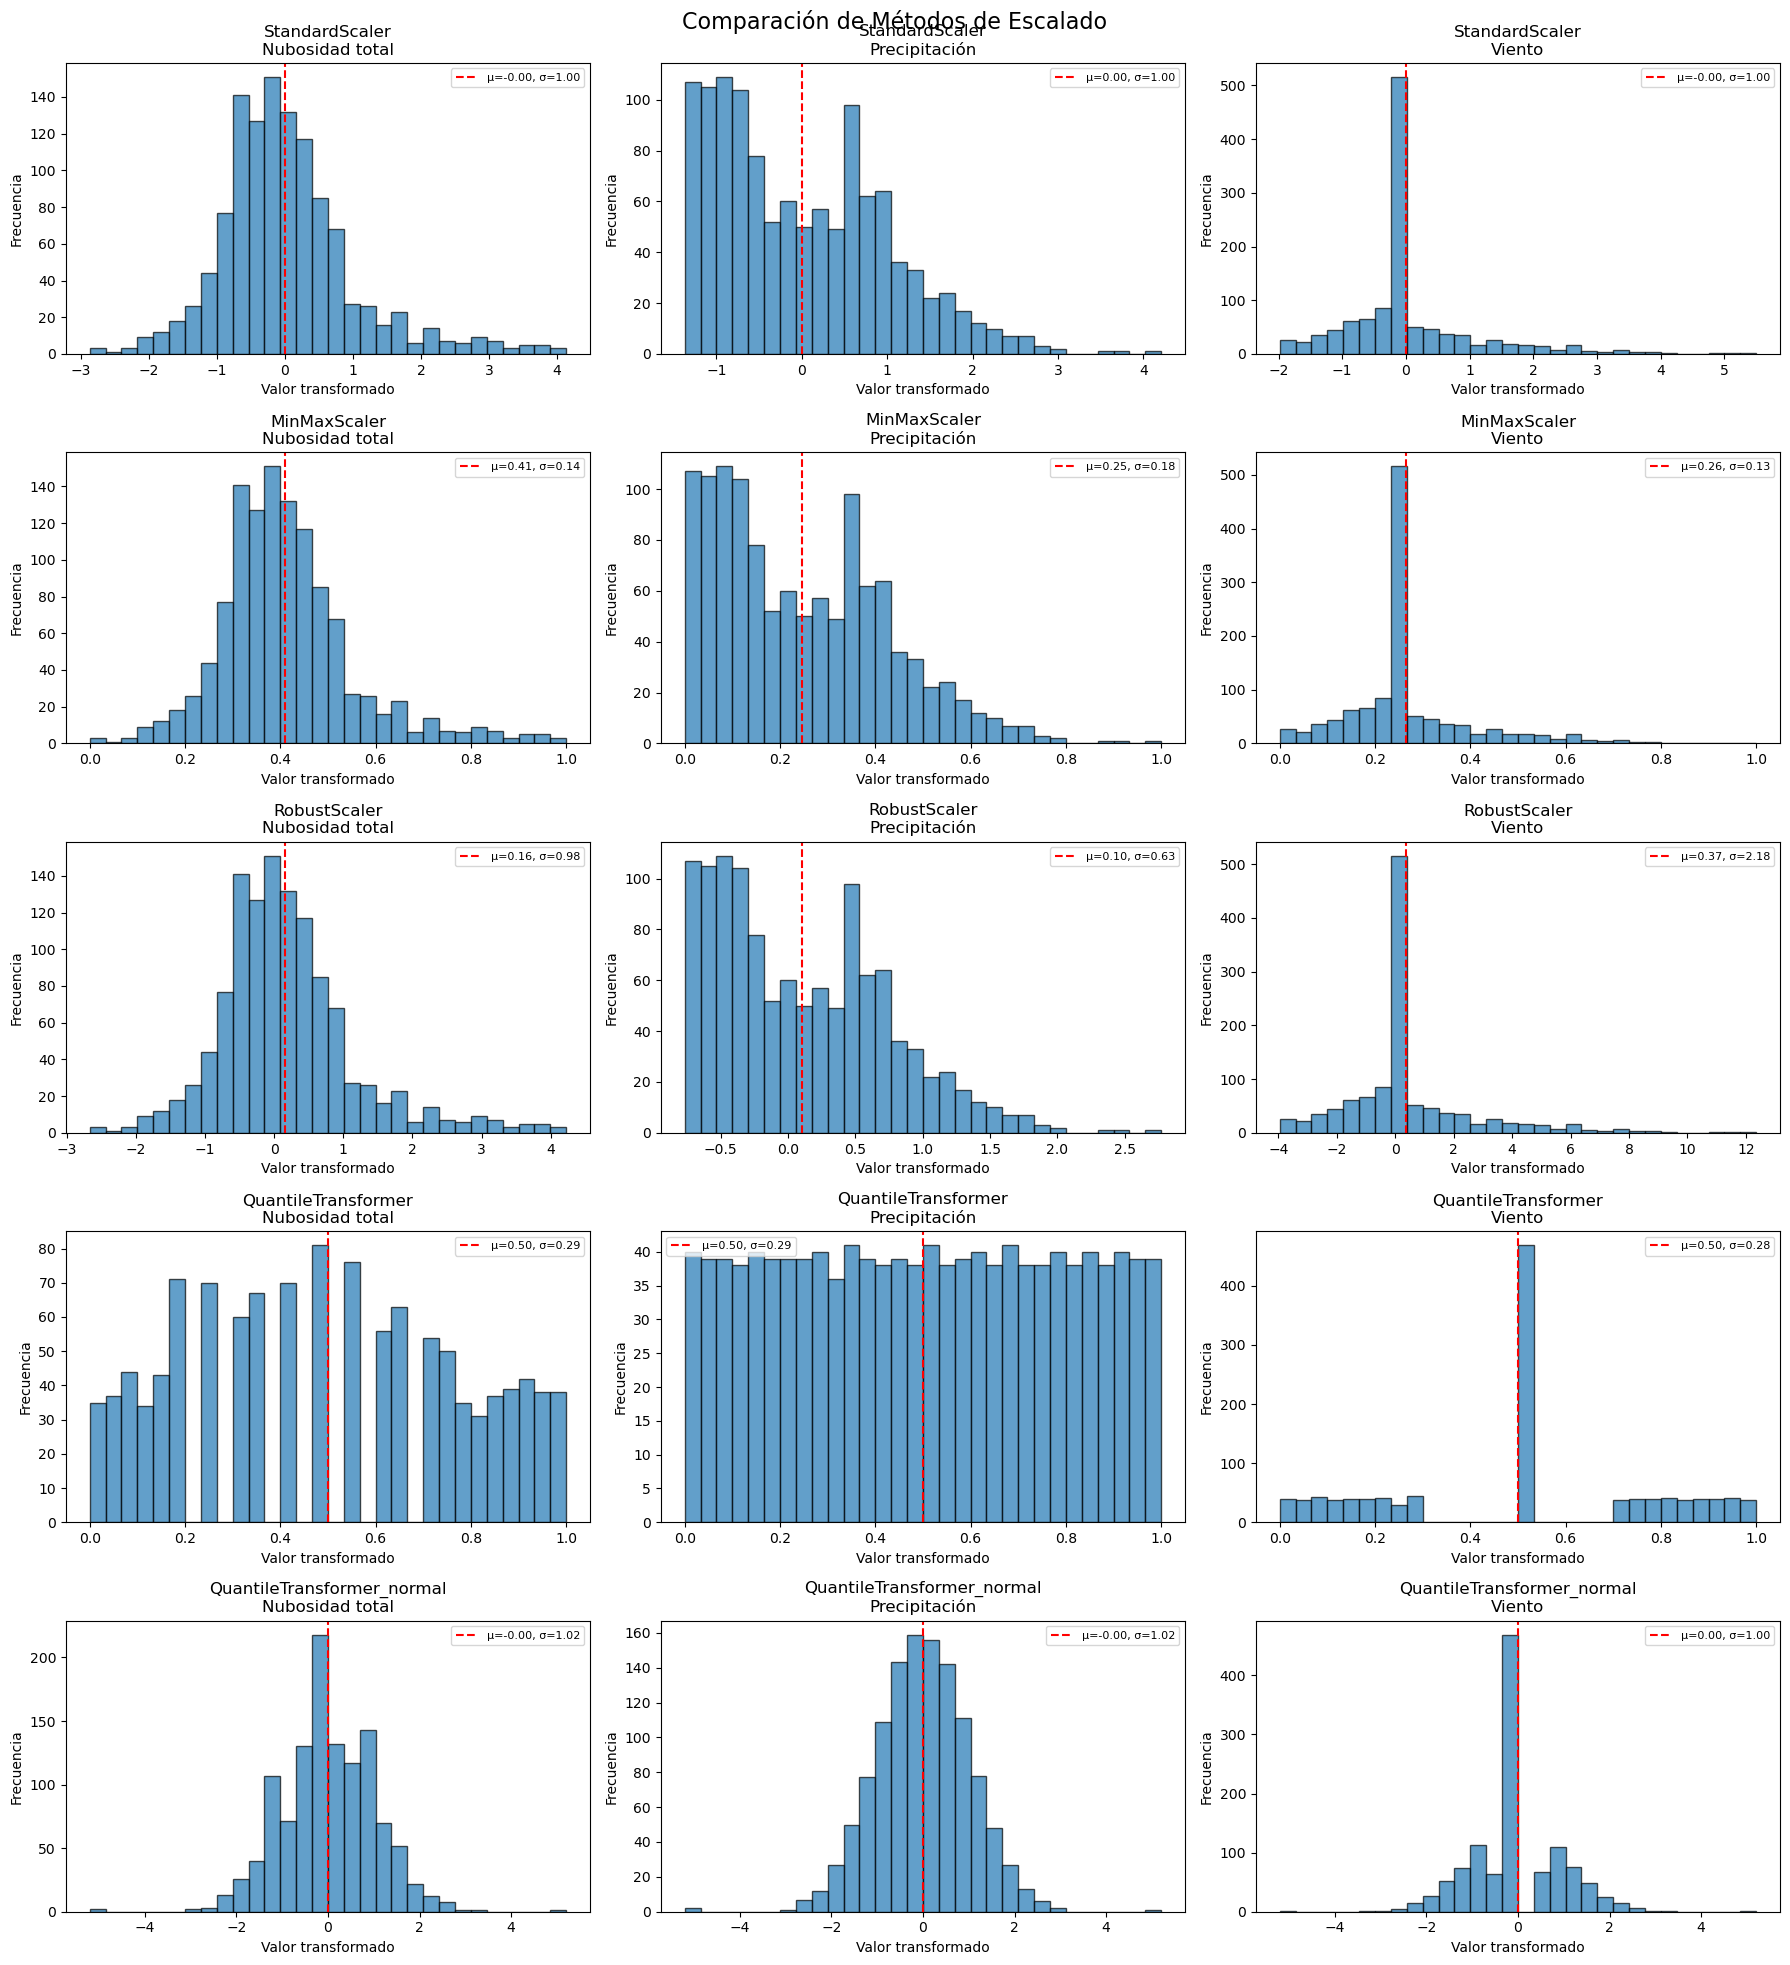

In [74]:
# ESCALADO Y NORMALIZACIÓN
print(f"\n=== ESCALADO Y NORMALIZACIÓN ===")

# Crear diferentes transformadores para comparar
transformers_numeric = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'QuantileTransformer': QuantileTransformer(output_distribution='uniform'),
    'QuantileTransformer_normal': QuantileTransformer(output_distribution='normal')
}

# Pipeline completo de transformación
def create_preprocessing_pipeline(numeric_scaler='StandardScaler', 
                                include_discretized=False):
    """
    Crea un pipeline de preprocesamiento completo
    """
    
    # Features a usar
    if include_discretized:
        # Incluir versión discretizada
        numeric_features = features_numericas
        categorical_features = features_categoricas + ['Precipitación_cat']
        X_input = X_discretized
    else:
        numeric_features = features_numericas
        categorical_features = features_categoricas
        X_input = X
    
    # Transformador para variables numéricas
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', transformers_numeric[numeric_scaler])
    ])
    
    # Transformador para variables categóricas
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Transformador para Mes (ordinal)
    mes_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', OrdinalEncoder(categories=[meses_orden], 
                                 handle_unknown='use_encoded_value', 
                                 unknown_value=-1))
    ])
    
    # Separar features categóricas
    categorical_nominal = ['Estación']
    if include_discretized:
        categorical_nominal.append('Precipitación_cat')
    
    # ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat_nominal', categorical_transformer, categorical_nominal),
            ('mes_ordinal', mes_transformer, ['Mes'])
        ],
        remainder='passthrough'
    )
    
    return preprocessor, X_input

# Aplicar diferentes escaladores y comparar
print("Comparando diferentes métodos de escalado:")

results_scaling = {}
for scaler_name in transformers_numeric.keys():
    print(f"\n--- {scaler_name} ---")
    
    # Crear pipeline
    preprocessor, X_input = create_preprocessing_pipeline(scaler_name)
    
    # Ajustar y transformar
    X_transformed = preprocessor.fit_transform(X_input)
    
    # Obtener nombres de features después de la transformación
    feature_names = []
    
    # Features numéricas
    feature_names.extend([f'num__{feat}' for feat in features_numericas])
    
    # Features categóricas nominales (One-Hot)
    cat_feature_names = preprocessor.named_transformers_['cat_nominal']['onehot'].get_feature_names_out(['Estación'])
    feature_names.extend([f'cat__{name}' for name in cat_feature_names])
    
    # Mes (ordinal)
    feature_names.append('mes_ordinal__Mes')
    
    # Crear DataFrame transformado
    X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)
    
    # Estadísticas de features numéricas transformadas
    numeric_cols = [col for col in X_transformed_df.columns if col.startswith('num__')]
    stats = X_transformed_df[numeric_cols].describe()
    
    print(f"Estadísticas después de {scaler_name}:")
    print(stats.loc[['mean', 'std', 'min', 'max']].round(3))
    
    results_scaling[scaler_name] = {
        'data': X_transformed_df,
        'stats': stats
    }

# Visualización de transformaciones
fig, axes = plt.subplots(len(transformers_numeric), len(features_numericas), 
                        figsize=(18, 20))
fig.suptitle('Comparación de Métodos de Escalado', fontsize=16)

for i, (scaler_name, result) in enumerate(results_scaling.items()):
    for j, feature in enumerate(features_numericas):
        col_name = f'num__{feature}'
        data = result['data'][col_name]
        
        axes[i, j].hist(data, bins=30, alpha=0.7, edgecolor='black')
        axes[i, j].set_title(f'{scaler_name}\n{feature}')
        axes[i, j].set_xlabel('Valor transformado')
        axes[i, j].set_ylabel('Frecuencia')
        
        # Estadísticas
        mean_val = data.mean()
        std_val = data.std()
        axes[i, j].axvline(mean_val, color='red', linestyle='--', 
                          label=f'μ={mean_val:.2f}, σ={std_val:.2f}')
        axes[i, j].legend(fontsize=8)

plt.tight_layout()
plt.show()

## Pipeline final


=== PIPELINE FINAL ===
Escalador seleccionado: StandardScaler
Justificación: StandardScaler es robusto para la mayoría de algoritmos de ML

Dimensiones finales: (1171, 102)
Features finales: ['num__Nubosidad total', 'num__Precipitación', 'num__Viento', 'cat__Estación_AEROPARQUE AERO', 'cat__Estación_AZUL AERO*', 'cat__Estación_BAHÍA BLANCA AERO', 'cat__Estación_BARILOCHE AERO', 'cat__Estación_BASE BELGRANO II', 'cat__Estación_BASE CARLINI (EX JÚBANY)', 'cat__Estación_BASE ESPERANZA', 'cat__Estación_BASE MARAMBIO', 'cat__Estación_BASE ORCADAS', 'cat__Estación_BASE SAN MARTÍN', 'cat__Estación_BERNARDO DE IRIGOYEN AERO', 'cat__Estación_BOLÍVAR AERO', 'cat__Estación_BUENOS AIRES OBSERVATORIO', 'cat__Estación_CATAMARCA AERO', 'cat__Estación_CERES AERO', 'cat__Estación_CHAMICAL AERO', 'cat__Estación_CHILECITO AERO', 'cat__Estación_COMODORO RIVADAVIA AERO', 'cat__Estación_CONCORDIA AERO', 'cat__Estación_CORONEL PRINGLES AERO*', 'cat__Estación_CORONEL SUÁREZ AERO', 'cat__Estación_CORRIENTES A

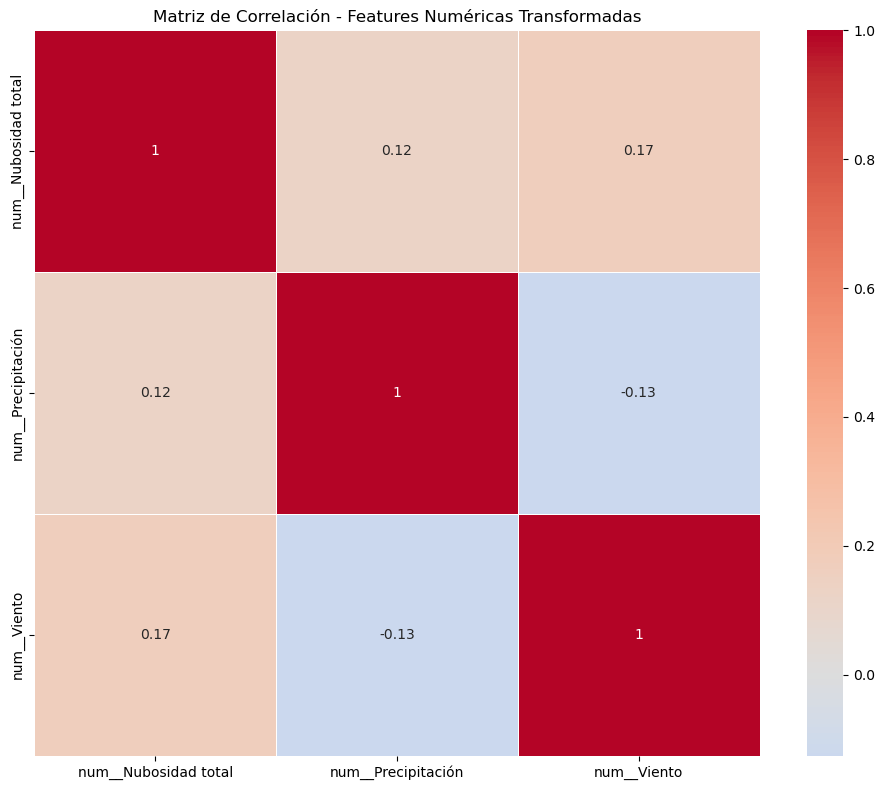

Matriz de correlación:
                      num__Nubosidad total  num__Precipitación  num__Viento
num__Nubosidad total                 1.000               0.123        0.169
num__Precipitación                   0.123               1.000       -0.126
num__Viento                          0.169              -0.126        1.000


In [75]:
# PIPELINE FINAL
print(f"\n=== PIPELINE FINAL ===")

# Standard Scaler
best_scaler = 'StandardScaler'
print(f"Escalador seleccionado: {best_scaler}")
print("Justificación: StandardScaler es robusto para la mayoría de algoritmos de ML")

# Pipeline final
final_preprocessor, X_final = create_preprocessing_pipeline(best_scaler, 
                                                          include_discretized=False)

# Ajustar y transformar datos finales
X_final_transformed = final_preprocessor.fit_transform(X_final)

# Nombres de features finales
final_feature_names = []
final_feature_names.extend([f'num__{feat}' for feat in features_numericas])

cat_names = final_preprocessor.named_transformers_['cat_nominal']['onehot'].get_feature_names_out(['Estación'])
final_feature_names.extend([f'cat__{name}' for name in cat_names])
final_feature_names.append('mes_ordinal__Mes')

X_final_df = pd.DataFrame(X_final_transformed, columns=final_feature_names)

print(f"\nDimensiones finales: {X_final_df.shape}")
print(f"Features finales: {final_feature_names}")
print(f"\nPrimeras 5 filas del dataset transformado:")
print(X_final_df.head())

# Análisis de correlación post-transformación
print(f"\n=== ANÁLISIS DE CORRELACIÓN POST-TRANSFORMACIÓN ===")
numeric_transformed_cols = [col for col in X_final_df.columns if col.startswith('num__')]
correlation_matrix = X_final_df[numeric_transformed_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Matriz de Correlación - Features Numéricas Transformadas')
plt.tight_layout()
plt.show()

print("Matriz de correlación:")
print(correlation_matrix.round(3))

---

## Reducción de la dimensionalidad


### PCA - Análisis de Componentes Principales

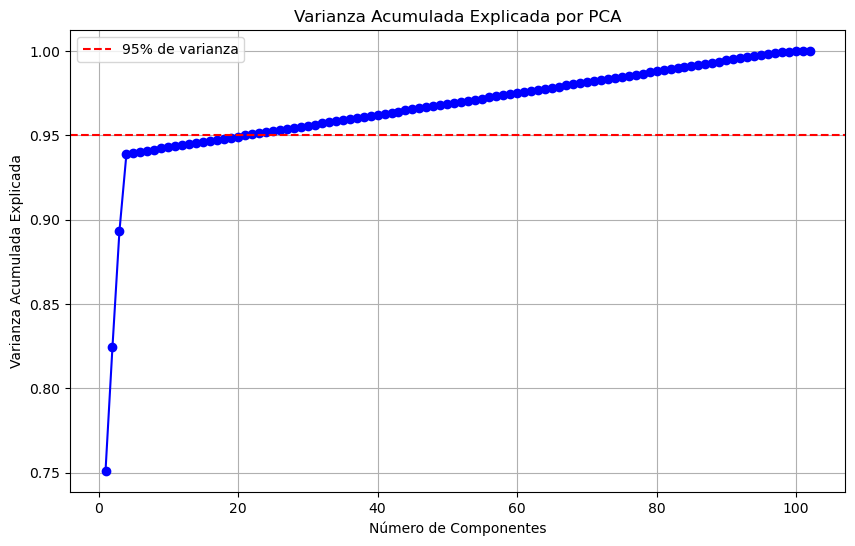

Número de componentes necesarios para explicar 95% de la varianza: 21


In [76]:
pca = PCA()
X_pca = pca.fit_transform(X_final_transformed)

# Calcular varianza explicada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Visualizar varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Varianza Acumulada Explicada por PCA')
plt.legend()
plt.grid(True)
plt.show()

# Encontrar número de componentes para 95% de varianza
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Número de componentes necesarios para explicar 95% de la varianza: {n_components_95}")

# Aplicar PCA con el número óptimo de componentes
pca_optimal = PCA(n_components=n_components_95)
X_pca_optimal = pca_optimal.fit_transform(X_final_transformed)


### t-SNE - t-Distributed Stochastic Neighbor Embedding

In [77]:
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_final_transformed)
tsne_time = time.time() - start_time

print(f"Tiempo de ejecución de t-SNE: {tsne_time:.2f} segundos")

Tiempo de ejecución de t-SNE: 4.32 segundos


## Aspectos Teóricos de PCA y t-SNE
El Análisis de Componentes Principales (PCA) es una transformación lineal que se caracteriza por maximizar la varianza y preservar la estructura global de los datos. Sus componentes son ortogonales entre sí, lo que permite identificar patrones dominantes en los datos de manera efectiva. Por otro lado, t-SNE (t-Distributed Stochastic Neighbor Embedding) es una transformación no lineal que se especializa en preservar la estructura local de los datos. Aunque es computacionalmente más costoso que PCA y no preserva las distancias globales, resulta ideal para la exploración de datos y la detección de clusters.

### UMAP - Uniform Manifold Approximation and Projection

In [78]:
start_time = time.time()
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_final_transformed)
umap_time = time.time() - start_time

print(f"Tiempo de ejecución de UMAP: {umap_time:.2f} segundos")

d:\Anaconda\envs\add-env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\add-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Tiempo de ejecución de UMAP: 3.23 segundos


## Aspectos Teóricos de UMAP
UMAP (Uniform Manifold Approximation and Projection) representa una técnica más moderna que combina las ventajas de t-SNE y PCA. Esta metodología se destaca por preservar tanto la estructura local como global de los datos, siendo más eficiente computacionalmente que t-SNE. Es particularmente efectiva para datasets grandes y mantiene mejor las relaciones entre clusters, lo que la convierte en una herramienta versátil para el análisis de datos.

## Visualizaciones

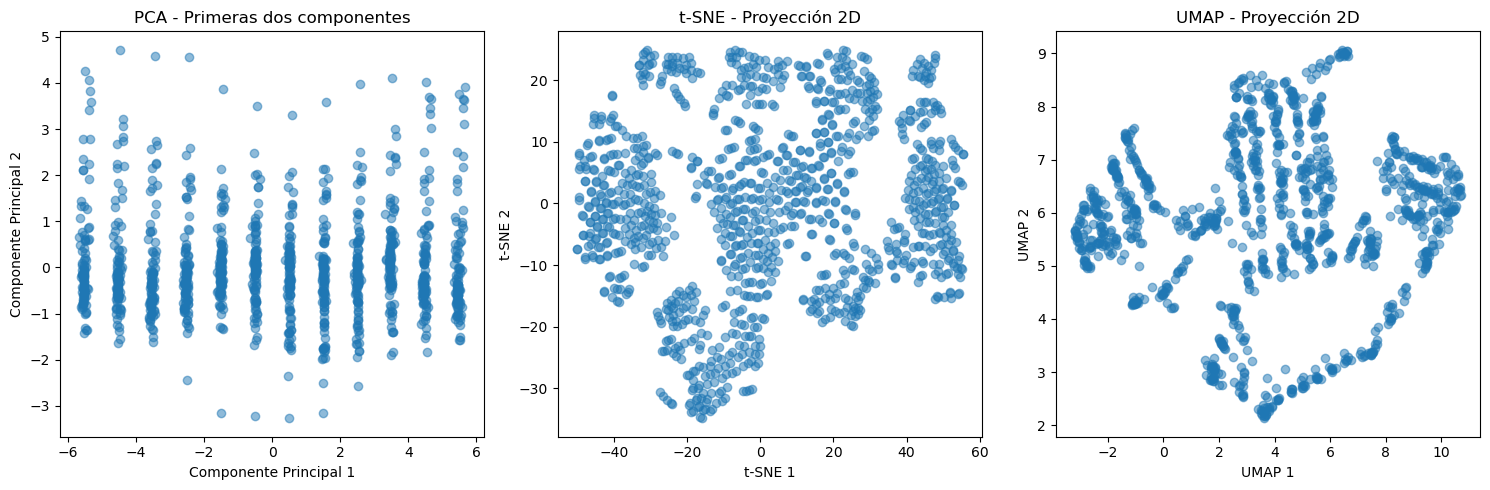

In [79]:
# Visualización de resultados
plt.figure(figsize=(15, 5))

# Visualizar PCA (primeras dos componentes)
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA - Primeras dos componentes')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Visualizar t-SNE
plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
plt.title('t-SNE - Proyección 2D')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Visualizar UMAP
plt.subplot(1, 3, 3)
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title('UMAP - Proyección 2D')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

## Implicaciones para Modelos a futuro
En el contexto de modelos, cada técnica presenta características distintivas. PCA reduce el ruido en los datos, mejora la eficiencia computacional, puede mejorar la generalización y mantiene la interpretabilidad de las relaciones lineales. t-SNE, por su parte, es más adecuado para visualización que para modelado, ya que puede distorsionar las relaciones globales y no se recomienda para modelado predictivo. UMAP ofrece un balance entre preservación local y global, puede ser útil para preprocesamiento de datos, tiene mejor rendimiento computacional que t-SNE y mantiene mejor la estructura de los datos.

## Recomendaciones de Uso
Las recomendaciones de uso varían según el objetivo y las características de los datos. PCA es recomendable cuando se necesita reducción de dimensionalidad para modelado, la interpretabilidad es importante y los datos tienen estructura lineal. t-SNE es más apropiado cuando el objetivo principal es la visualización, se necesita explorar la estructura local de los datos y los datos presentan estructura no lineal. UMAP, por su parte, es la opción preferida cuando se necesita un balance entre preservación local y global, el dataset es grande, se requiere eficiencia computacional y se necesita una visualización de alta calidad.